In [387]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
# from google.colab import drive

df = pd.read_csv('american_bankruptcy.csv')

df = df.drop(columns = ['company_name'])
df = df.drop(columns = ['year'])

print(df.head(10))

  status_label       X1        X2      X3       X4       X5      X6       X7  \
0        alive  511.267   833.107  18.373   89.031  336.018  35.163  128.348   
1        alive  485.856   713.811  18.577   64.367  320.590  18.531  115.187   
2        alive  436.656   526.477  22.496   27.207  286.588 -58.939   77.528   
3        alive  396.412   496.747  27.172   30.745  259.954 -12.410   66.322   
4        alive  432.204   523.302  26.680   47.491  247.245   3.504  104.661   
5        alive  474.542   598.172  27.950   61.774  255.477  15.453  127.121   
6        alive  624.454   704.081  29.222   91.877  323.592  35.163  136.272   
7        alive  645.721   837.171  32.199  118.907  342.593  58.660  181.691   
8        alive  783.431  1080.895  39.952  168.522  435.608  75.144  202.472   
9        alive  851.312  1110.677  40.551  166.080  477.424  78.651  227.300   

          X8        X9       X10      X11      X12      X13      X14      X15  \
0   372.7519  1024.333   740.998  180.

In [389]:
# Data Cleaning

missing_values = df.isnull().sum()
print('\nMissing values per column:\n', missing_values)

duplicates = df.duplicated().sum()
print('\nDuplicates in the dataset:', duplicates)


Missing values per column:
 status_label    0
X1              0
X2              0
X3              0
X4              0
X5              0
X6              0
X7              0
X8              0
X9              0
X10             0
X11             0
X12             0
X13             0
X14             0
X15             0
X16             0
X17             0
X18             0
dtype: int64

Duplicates in the dataset: 0


In [391]:
# Feature Encoding

print('\nLabels in the dataset:', df['status_label'].unique())

df['status_encoding'] = df['status_label'].map({'alive': 0, 'failed': 1})
df['status_encoding'] = df['status_encoding'].astype(int)
df = df.drop(columns = ['status_label'])
print(df.head(10))


Labels in the dataset: ['alive' 'failed']
        X1        X2      X3       X4       X5      X6       X7         X8  \
0  511.267   833.107  18.373   89.031  336.018  35.163  128.348   372.7519   
1  485.856   713.811  18.577   64.367  320.590  18.531  115.187   377.1180   
2  436.656   526.477  22.496   27.207  286.588 -58.939   77.528   364.5928   
3  396.412   496.747  27.172   30.745  259.954 -12.410   66.322   143.3295   
4  432.204   523.302  26.680   47.491  247.245   3.504  104.661   308.9071   
5  474.542   598.172  27.950   61.774  255.477  15.453  127.121   522.6794   
6  624.454   704.081  29.222   91.877  323.592  35.163  136.272   882.6283   
7  645.721   837.171  32.199  118.907  342.593  58.660  181.691  1226.1925   
8  783.431  1080.895  39.952  168.522  435.608  75.144  202.472   747.5434   
9  851.312  1110.677  40.551  166.080  477.424  78.651  227.300   571.5948   

         X9       X10      X11      X12      X13      X14      X15       X16  \
0  1024.333   740.

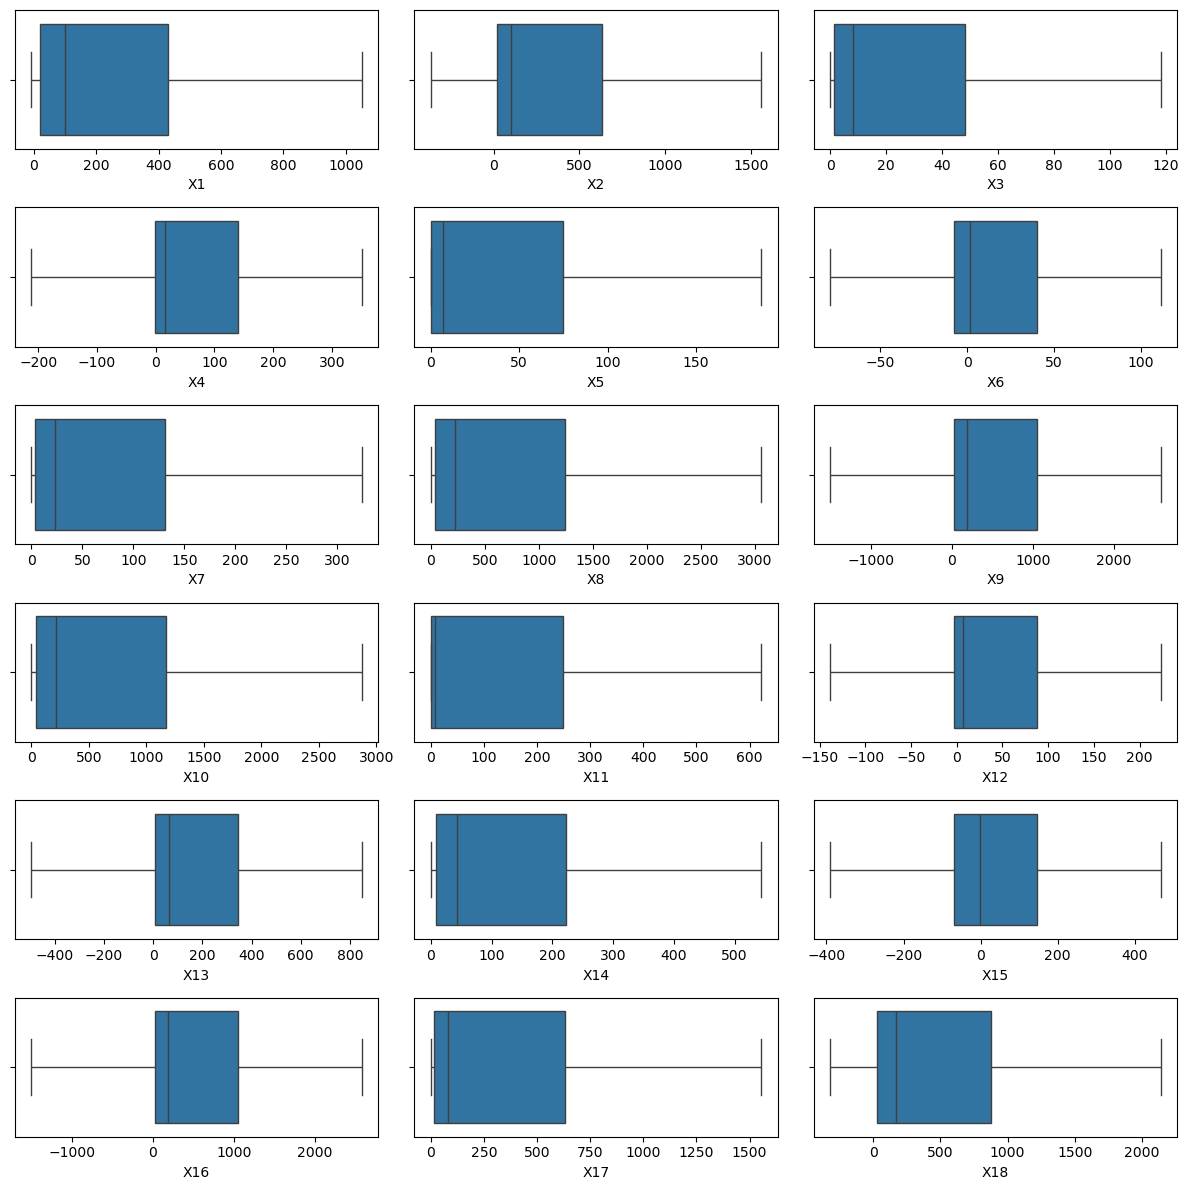

In [393]:
# Outlier Detection

features_to_plot = df.columns[df.columns != 'status_encoding']

for feature in features_to_plot:
    Q1 = df[feature].quantile(0.25)
    Q2 = df[feature].quantile(0.50)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lowerBound = Q1 - 1.5 * IQR
    upperBound = Q3 + 1.5 * IQR
    df[feature] = df[feature].clip(lower=lowerBound, upper=upperBound)

num_features = len(features_to_plot)
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

plt.figure(figsize=(12, 2 * num_rows))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x=df[feature])
plt.tight_layout()
plt.show()

         X1        X2        X3        X4        X5        X6        X7  \
0  0.545408  0.606954 -0.180899  0.307077  1.969652  0.397357  0.454232   
1  2.033746  2.007609  2.024514  1.962670  1.969652  1.790705  2.028951   
2 -0.147620  0.035134 -0.545747 -0.253433  1.645842  0.175204 -0.741835   
3  2.033746  2.007609  2.024514  1.962670  1.969652  1.790705  2.028951   
4 -0.640089 -0.566806 -0.409760 -0.392274 -0.579661 -0.170497 -0.409254   
5  0.546506  2.007609  2.024514  1.962670 -0.420456  1.790705  1.872916   
6  0.060091  1.018303  2.024514  1.843244 -0.489082 -1.815293  0.306905   
7  0.547448 -0.303947 -0.101694 -2.201872 -0.692564 -1.815293 -0.476507   
8 -0.602549 -0.628201 -0.104128 -0.373374 -0.681011 -0.175008 -0.585427   
9 -0.636384 -0.641964 -0.190659 -0.479958 -0.692564 -1.815293 -0.532520   

         X8        X9       X10       X11       X12       X13       X14  \
0  0.163244  0.451808  0.005666 -0.659002  0.587659  0.400548  0.688500   
1  2.016142  2.020872  2

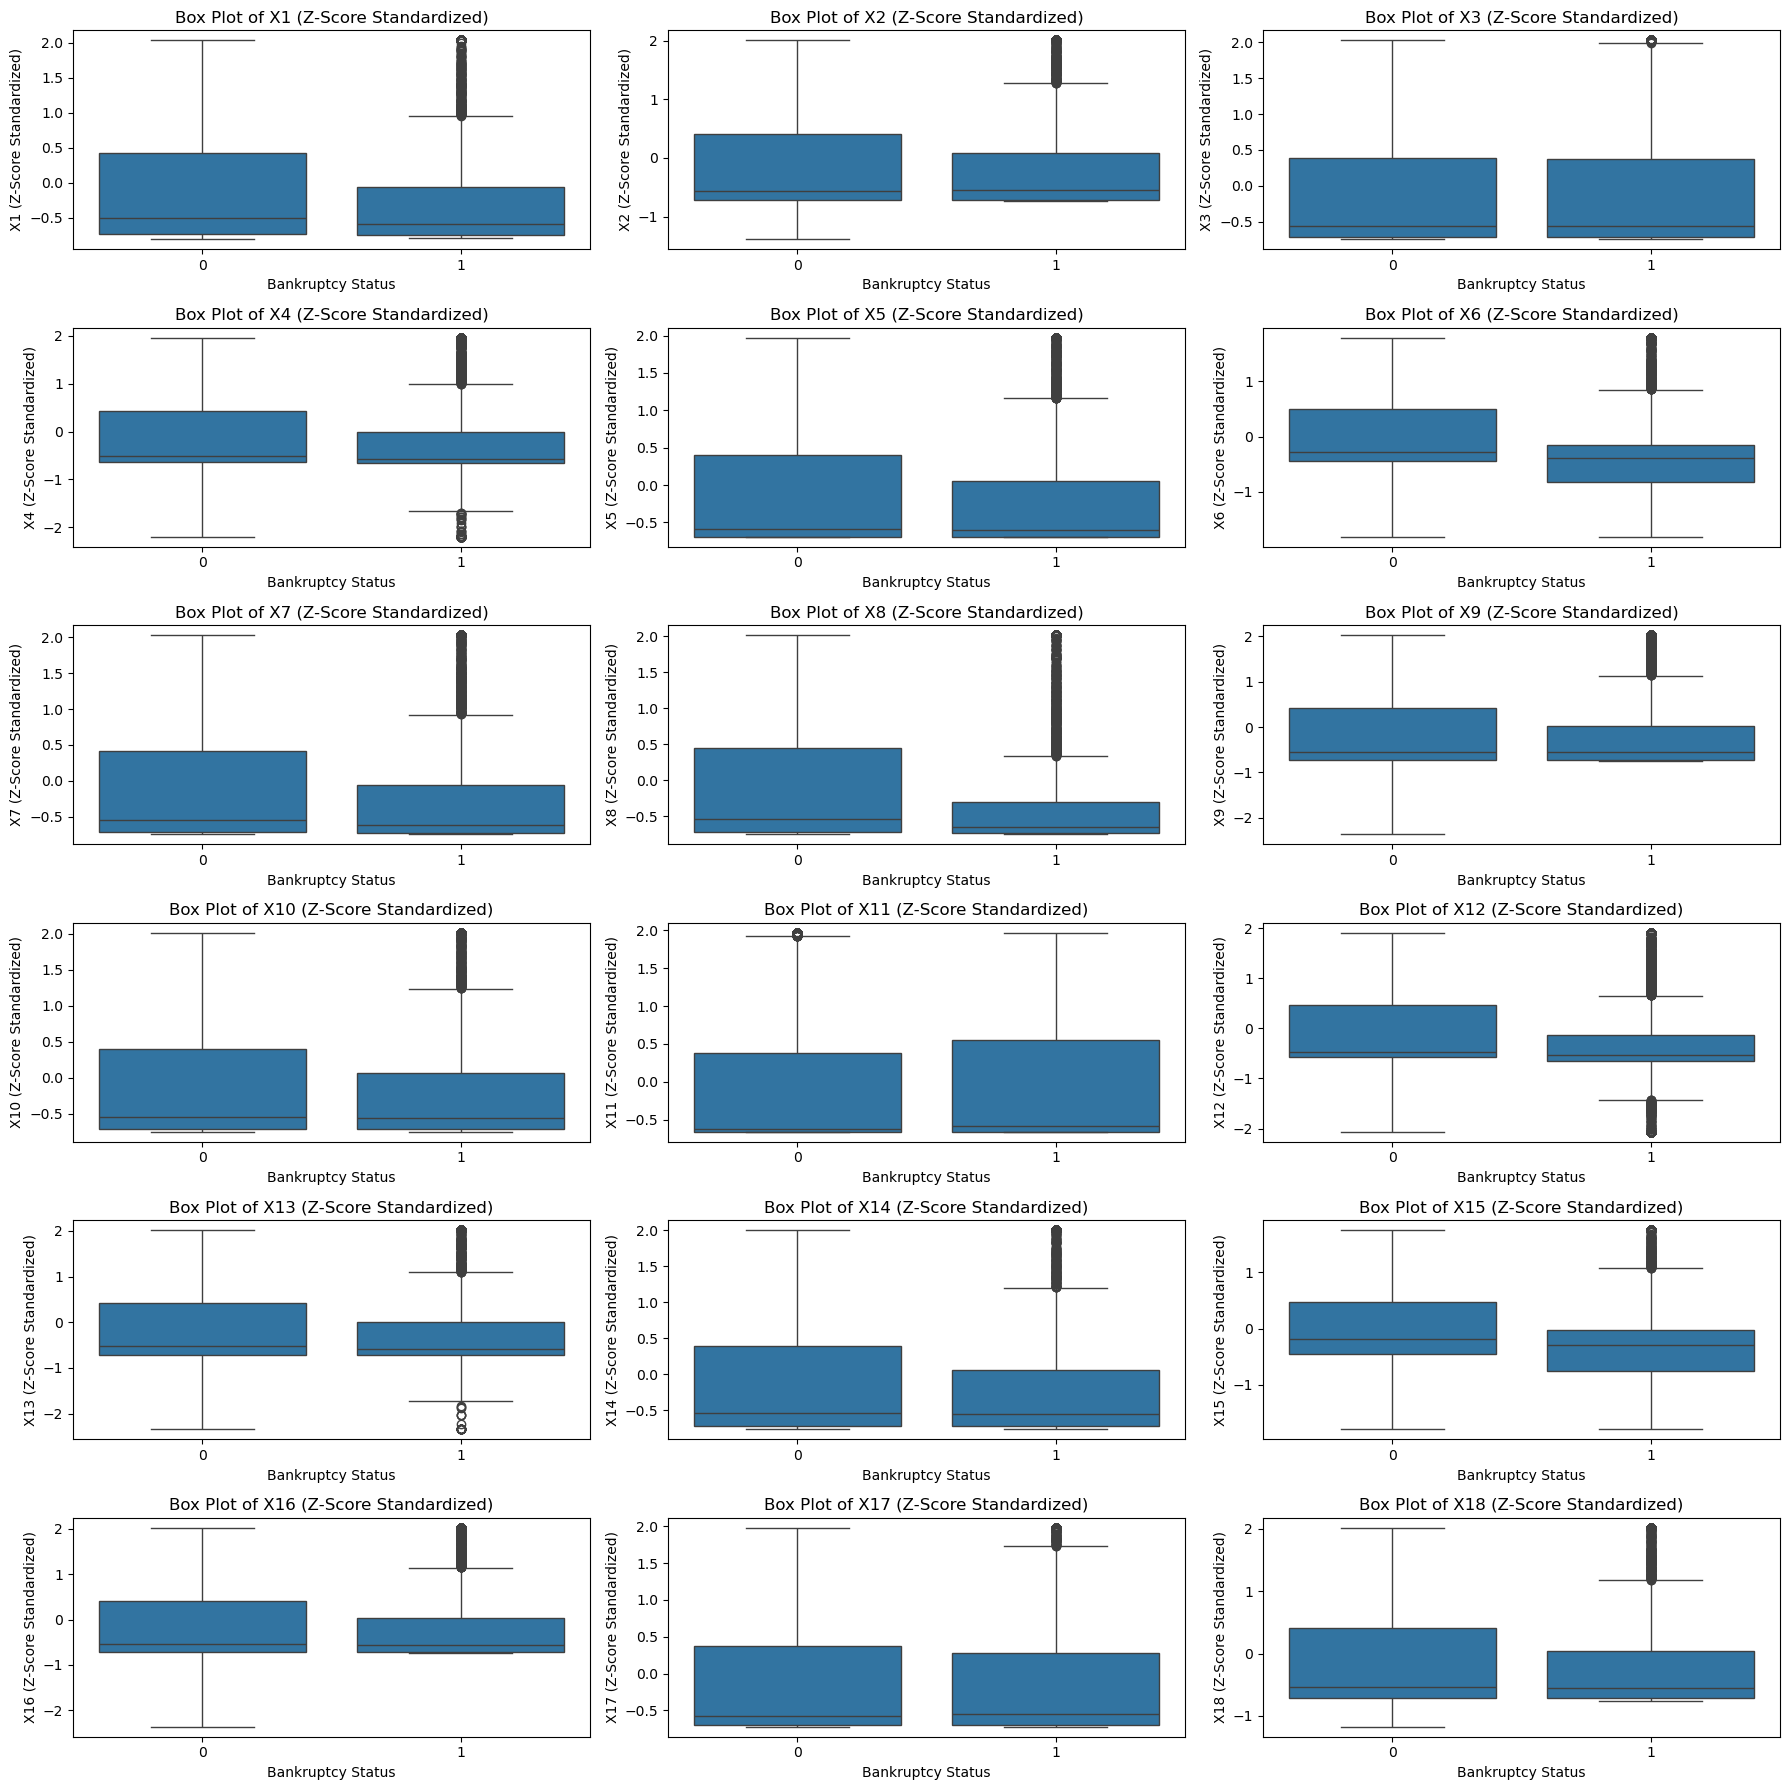

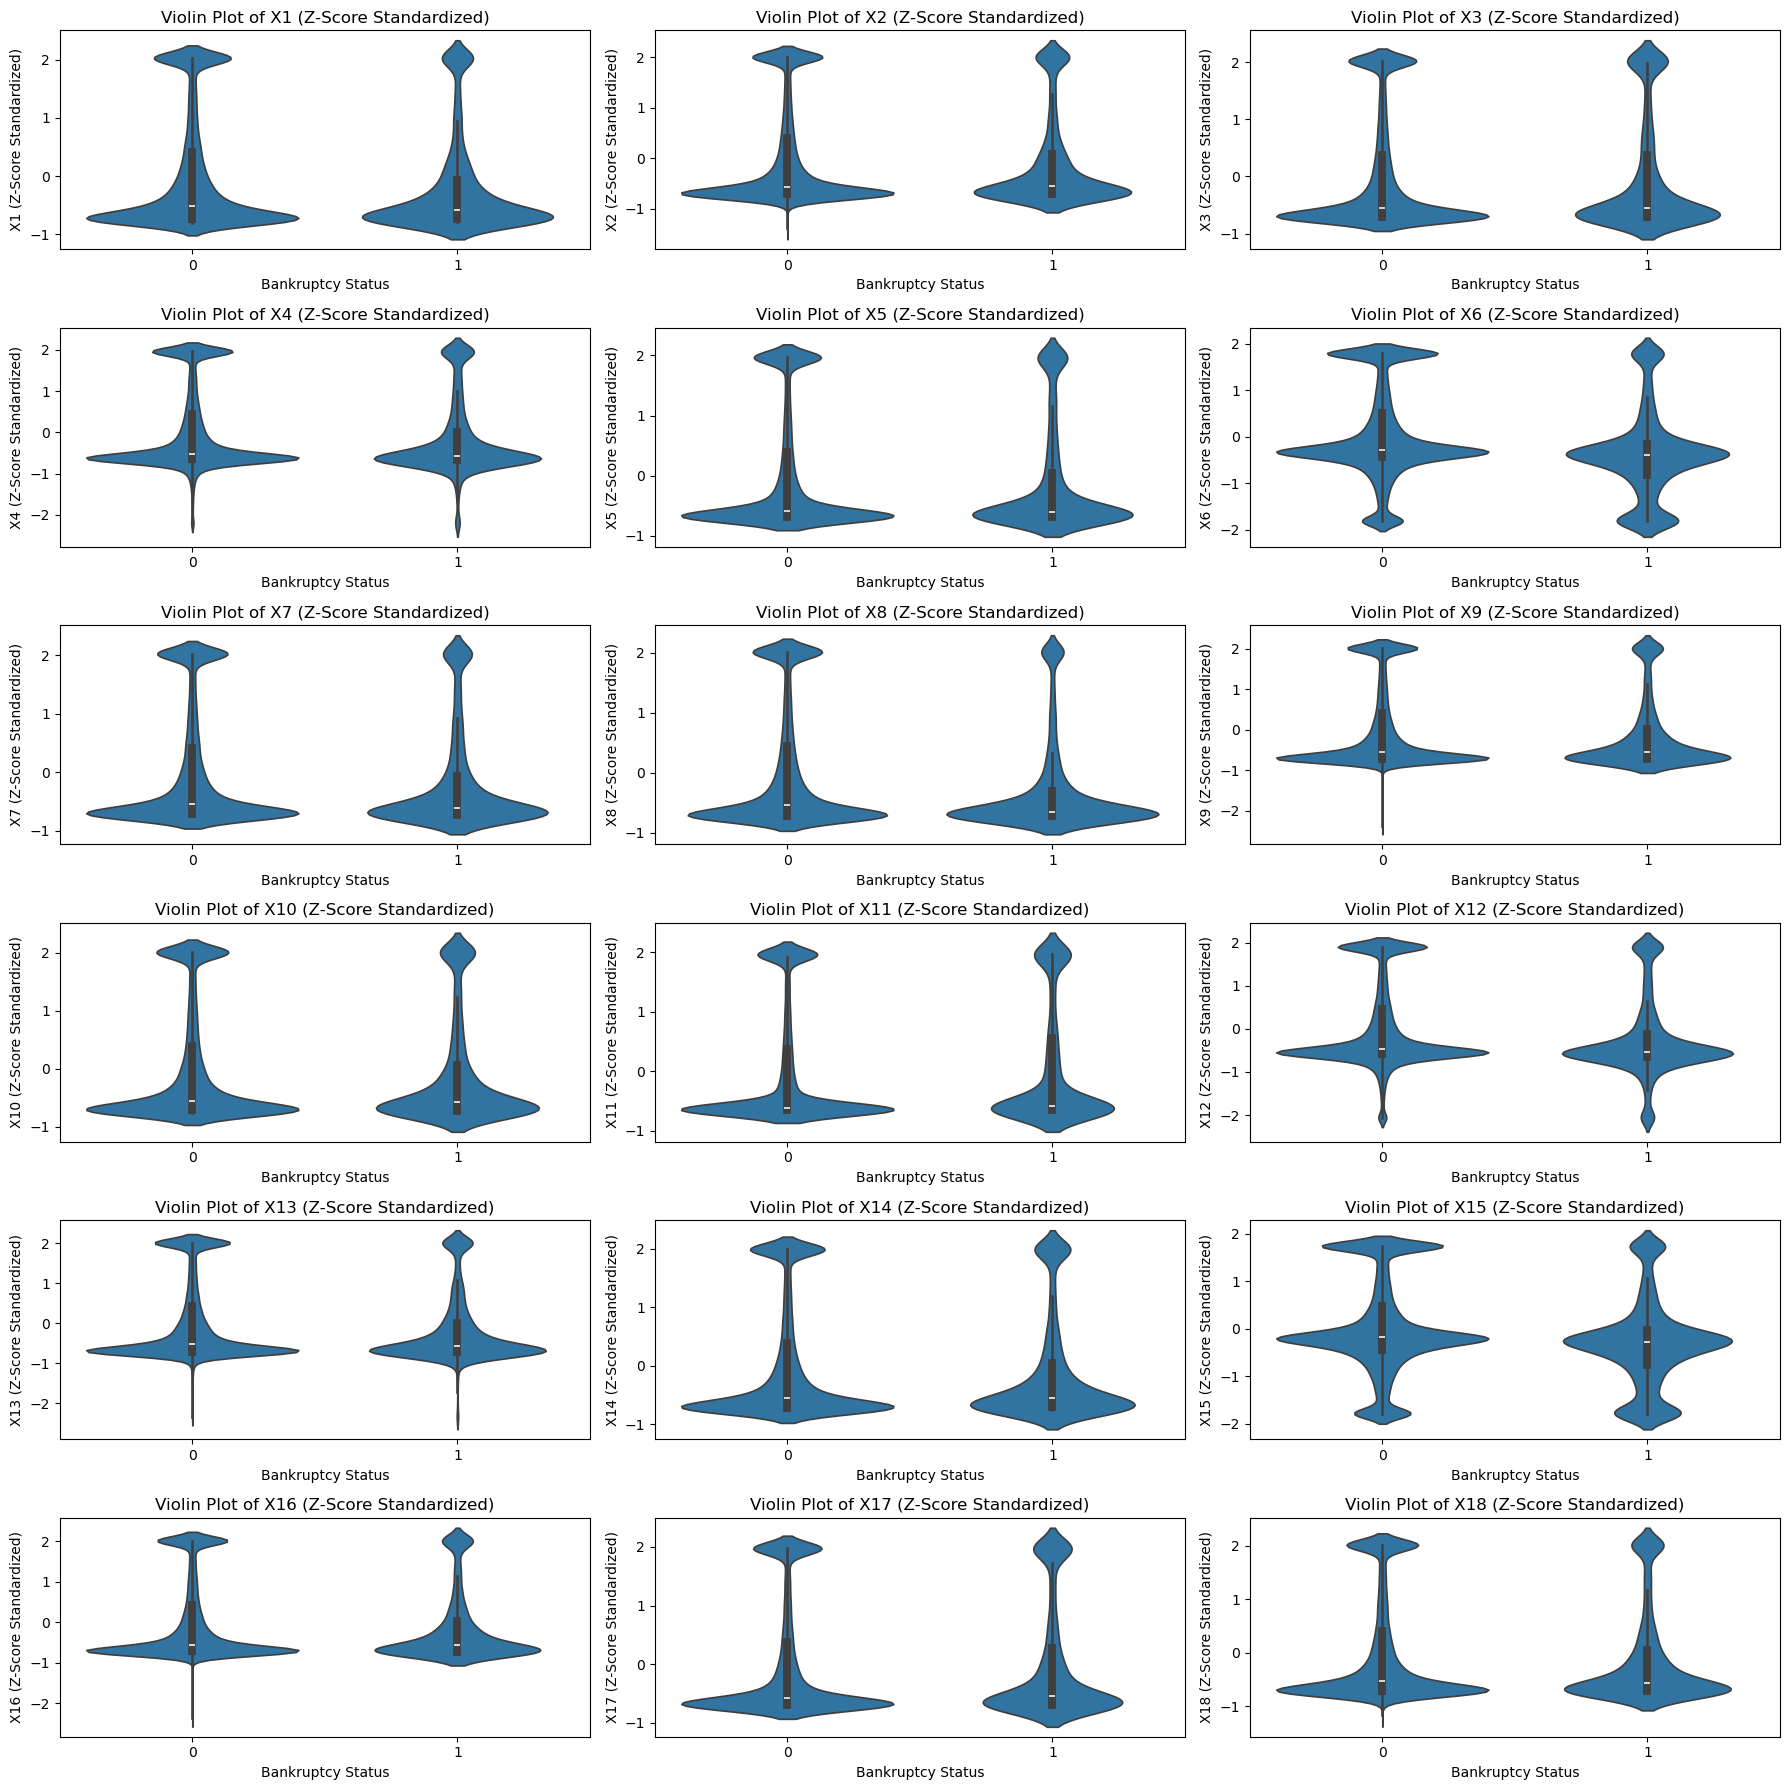

In [397]:
# Data Scaling/Standardization

scaler = StandardScaler()

X = df.iloc[:, :-1]
y = df['status_encoding']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, test_size=0.20, shuffle=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_scaled = pd.concat([pd.DataFrame(X_train_scaled, columns=X.columns), pd.DataFrame(y_train.reset_index(drop=True), columns =['status_encoding'])], axis=1)
test_scaled = pd.concat([pd.DataFrame(X_test_scaled, columns=X.columns), pd.DataFrame(y_test.reset_index(drop=True), columns =['status_encoding'])], axis=1)
df_scaled = pd.concat([train_scaled, test_scaled], axis=0)
print(df_scaled.head(10))

print('/n')

diagram_columns = 3
attribute_columns = df_scaled.shape[1] - 1
diagram_rows = math.ceil(attribute_columns / diagram_columns)

row_index = 0
column_index = 0
fig, axes = plt.subplots(diagram_rows, diagram_columns, figsize=(18, diagram_rows * 3))
for column in df_scaled.columns[:-1]:
    sns.boxplot(x='status_encoding', y=column, data=df_scaled, ax=axes[row_index, column_index])
    axes[row_index, column_index].set_title(f'Box Plot of {column} (Z-Score Standardized)')
    axes[row_index, column_index].set_xlabel('Bankruptcy Status')
    axes[row_index, column_index].set_ylabel(f'{column} (Z-Score Standardized)')
    column_index += 1
    if column_index == diagram_columns:
        row_index += 1
        column_index = 0
plt.tight_layout()
plt.show()

print('\n')

row_index = 0
column_index = 0
fig, axes = plt.subplots(diagram_rows, diagram_columns, figsize=(18, diagram_rows * 3))
for column in df_scaled.columns[:-1]:
    sns.violinplot(x='status_encoding', y=column, data=df_scaled, ax=axes[row_index, column_index])
    axes[row_index, column_index].set_title(f'Violin Plot of {column} (Z-Score Standardized)')
    axes[row_index, column_index].set_xlabel('Bankruptcy Status')
    axes[row_index, column_index].set_ylabel(f'{column} (Z-Score Standardized)')
    column_index += 1
    if column_index == diagram_columns:
        row_index += 1
        column_index = 0
plt.tight_layout()
plt.show()

In [415]:
# Applying the Logistic Regression Model

param_grid = {
    'penalty': ['l1', 'l2'], # L1 and L2 regularization 
    'C': [0.01, 0.1, 1, 10, 100], # C is 1 / lambda (i.e. the inverse of the regularization parameter)
    'max_iter': [100, 200, 300, 400] # The maximum number of iterations, which is similar, but not analogous to epochs
}

model = LogisticRegression(solver='liblinear')

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(X_train_scaled, y_train)

best_params = grid_result.best_params_
best_score = grid_result.best_score_

print('The Best Model\'s Hyper-Parameters:', best_params)
print('Accuracy of the Best Model: {:.2f}%'.format(best_score * 100))

The Best Model's Hyper-Parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2'}
Accuracy of the Best Model: 93.33%


In [417]:
best_model = LogisticRegression(penalty=best_params['penalty'], C=best_params['C'], solver='liblinear', max_iter=best_params['max_iter'])

history = best_model.fit(X_train_scaled, y_train) # Can use history for plotting useful graphs

y_pred = best_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)

print('Accuracy of the Best Model on the Testing Data: {:.2f}%'.format(accuracy * 100))

Accuracy of the Best Model on the Testing Data: 93.54%


Accuracy of the Best Model With the Threshold 0.5: 93.54%


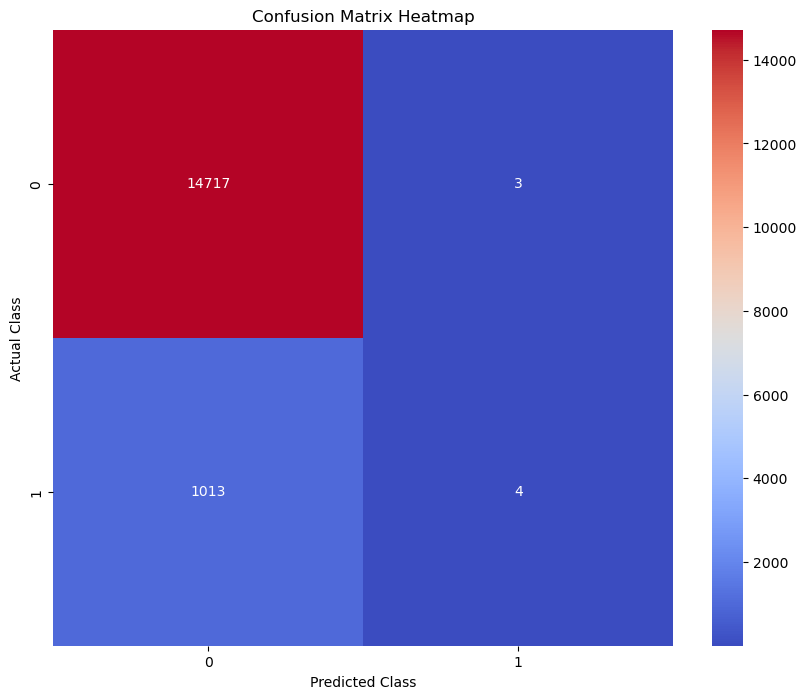

In [474]:
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

threshold = 0.5

y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred_adjusted)

print(f'Accuracy of the Best Model With the Threshold {threshold}: {accuracy * 100:.2f}%')

cm = confusion_matrix(y_test, y_pred_adjusted)

# Visualize correlation matrix using heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()